# LDC Demand Forecasting
---

In [127]:
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.metrics import gaussian_nlpd, rmse
from src.model import BLR

plt.style.use("seaborn-v0_8")

## Demand Data Preparation
---

Let's start by loading the demand data.

In [2]:
demand_df = pd.read_csv("data/demand_data.csv")
demand_df

,Unnamed: 0,Date,Value
0,3222,2016-01-01,193.99
1,3223,2016-01-02,166.00
2,3224,2016-01-03,173.02
3,3225,2016-01-04,188.62
4,3226,2016-01-05,186.69
...,...,...,...
2585,208,2023-01-29,180.88
2586,200,2023-01-30,185.45
2587,203,2023-01-31,185.12
2588,1538,NaN,1256.00


In [3]:
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2590 entries, 0 to 2589
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2590 non-null   int64  
 1   Date        2588 non-null   object 
 2   Value       2590 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 60.8+ KB


We can see that two of the values in the date column are `nan`s, and we have an unnecessary column which we can drop.

In [4]:
demand_df = demand_df.drop("Unnamed: 0", axis=1).dropna()
demand_df.rename(columns={"Value":"Demand"}, inplace=True)
demand_df

,Date,Demand
0,2016-01-01,193.99
1,2016-01-02,166.00
2,2016-01-03,173.02
3,2016-01-04,188.62
4,2016-01-05,186.69
...,...,...
2583,2023-01-27,207.61
2584,2023-01-28,191.45
2585,2023-01-29,180.88
2586,2023-01-30,185.45


Let's visualise the LDC demand versus time.

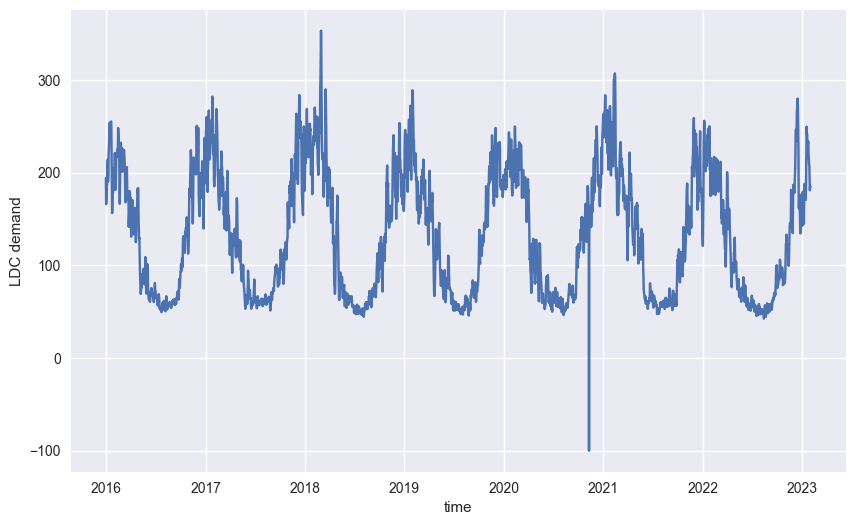

In [5]:
time = [datetime.strptime(t, '%Y-%m-%d') for t in demand_df["Date"].to_list()]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(time, demand_df["Demand"])
ax.set_xlabel("time")
ax.set_ylabel("LDC demand")
plt.show()

We can see that we have one fairly obvious outlier towards the end of 2020 (I am assuming LDC demand cannot be negative). Let's replace this value with the average of the demand value the day before and the day after the outlier (there are more sophisticated ways of replacing outliers, but this simple linear interpolation should be perfectly sufficient for this case).

In [6]:
outlier_idx = np.argwhere(demand_df["Demand"] < 0)[0][0]
demand_df["Demand"].iloc[outlier_idx] = (
    demand_df["Demand"].iloc[outlier_idx - 1] + 
    demand_df["Demand"].iloc[outlier_idx + 1]
) / 2

/var/folders/b2/qsstvzks76l75ftlnfwkd4zc0000gn/T/ipykernel_8482/3577677957.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demand_df["Demand"].iloc[outlier_idx] = (


Let's see how this looks now.

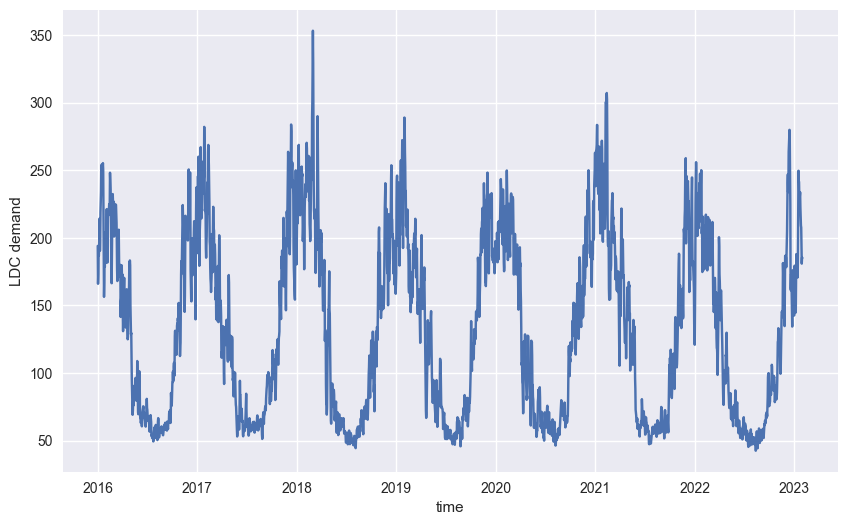

In [7]:
time = [datetime.strptime(t, '%Y-%m-%d') for t in demand_df["Date"].to_list()]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(time, demand_df["Demand"])
ax.set_xlabel("time")
ax.set_ylabel("LDC demand")
plt.show()

This looks much better! The trend is really periodic, which makes a lot of sense. Honestly, it would probably be possible to make a reasonable forecast using time as the only input feature, for example using a (sparse variational) Gaussian process with a clevely constructed kernel. However, we are fortunate enough to have access to weather data to help us build our forecasting model.

## Weather Data Preparation
---

Let's take a look at the weather data.

In [8]:
weather_df = pd.read_csv("data/weather_data.csv")
weather_df

,Unnamed: 0,validdate,display_name,culdrose - weather station,edinburgh - weather station,london - weather station,lydd - weather station,manchester - weather station,shawbury - weather station,yeovilton - weather station
0,0,2016-01-01 00:00:00,Temperature (2m),5.4,3.5,4.5,7.2,3.3,2.6,2.9
1,1,2016-01-01 00:00:00,Wind Speed (10m),3.4,6.3,3.5,5.8,3.5,2.6,2.8
2,2,2016-01-01 01:00:00,Temperature (2m),5.5,3.4,3.9,6.3,2.9,2.0,2.1
3,3,2016-01-01 01:00:00,Wind Speed (10m),3.8,6.2,2.5,4.7,3.0,2.5,2.1
4,4,2016-01-01 02:00:00,Temperature (2m),5.9,3.3,2.6,5.6,2.1,0.7,1.6
...,...,...,...,...,...,...,...,...,...,...
124939,124939,2023-02-15 21:00:00,Wind Speed (10m),5.9,6.7,4.1,5.2,2.6,2.9,2.5
124940,124940,2023-02-15 22:00:00,Temperature (2m),9.7,9.0,9.0,8.5,5.3,6.5,8.0
124941,124941,2023-02-15 22:00:00,Wind Speed (10m),7.0,6.1,3.7,5.2,3.0,3.6,2.9
124942,124942,2023-02-15 23:00:00,Temperature (2m),9.8,8.9,8.7,8.4,5.7,7.0,8.2


In [9]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124944 entries, 0 to 124943
Data columns (total 10 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    124944 non-null  int64  
 1   validdate                     124944 non-null  object 
 2   display_name                  124944 non-null  object 
 3   culdrose - weather station    124944 non-null  float64
 4   edinburgh - weather station   124944 non-null  float64
 5   london - weather station      124944 non-null  float64
 6   lydd - weather station        124944 non-null  float64
 7   manchester - weather station  124944 non-null  float64
 8   shawbury - weather station    124944 non-null  float64
 9   yeovilton - weather station   124944 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 9.5+ MB


It looks like we don't have any `nan`s in the weather data, but we once again have an unnecessary column which we can drop. The weather station names are also a bit verbose -- let's trim those down a bit.

In [10]:
weather_df = weather_df.drop("Unnamed: 0", axis=1)
weather_df.columns = weather_df.columns.str.replace(" - weather station", "")

We can also that the rows seemingly alternate between temperature and wind speed measurements, which we will want to separate. Let's split these into two separate `DataFrame`s, then concatenate them together horizontally.

In [11]:
temperature_df = weather_df[weather_df.display_name == "Temperature (2m)"]
temperature_df.set_index(pd.to_datetime(temperature_df["validdate"]), inplace=True)
temperature_df = temperature_df.drop(["validdate", "display_name"], axis=1)
temperature_df = temperature_df.add_suffix("_temperature")

wind_speed_df = weather_df[weather_df.display_name == "Wind Speed (10m)"]
wind_speed_df.set_index(pd.to_datetime(wind_speed_df["validdate"]), inplace=True)
wind_speed_df = wind_speed_df.drop(["validdate", "display_name"], axis=1)
wind_speed_df = wind_speed_df.add_suffix("_wind_speed")

weather_df = pd.concat([temperature_df, wind_speed_df], axis=1)
weather_df

,culdrose_temperature,edinburgh_temperature,london_temperature,lydd_temperature,manchester_temperature,shawbury_temperature,yeovilton_temperature,culdrose_wind_speed,edinburgh_wind_speed,london_wind_speed,lydd_wind_speed,manchester_wind_speed,shawbury_wind_speed,yeovilton_wind_speed
validdate,,,,,,,,,,,,,,
2016-01-01 00:00:00,5.4,3.5,4.5,7.2,3.3,2.6,2.9,3.4,6.3,3.5,5.8,3.5,2.6,2.8
2016-01-01 01:00:00,5.5,3.4,3.9,6.3,2.9,2.0,2.1,3.8,6.2,2.5,4.7,3.0,2.5,2.1
2016-01-01 02:00:00,5.9,3.3,2.6,5.6,2.1,0.7,1.6,4.8,5.9,1.8,3.6,2.1,2.2,1.6
2016-01-01 03:00:00,6.7,3.3,1.3,4.7,1.3,0.3,1.6,5.5,5.0,1.8,3.0,1.9,2.1,2.0
2016-01-01 04:00:00,7.2,3.1,1.3,4.4,1.0,0.1,1.8,6.5,4.2,1.7,2.2,2.2,2.0,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-15 19:00:00,9.1,8.6,10.2,8.4,6.7,6.4,8.9,4.5,6.8,4.5,4.9,2.7,2.6,2.4
2023-02-15 20:00:00,9.2,8.7,10.1,8.5,5.9,5.9,7.7,5.1,6.9,4.5,5.0,2.6,2.7,2.2
2023-02-15 21:00:00,9.5,9.1,9.9,8.5,5.9,6.1,7.9,5.9,6.7,4.1,5.2,2.6,2.9,2.5


We can see that both the temperature and wind speed data are comprised of hourly measurements, whereas the demand readings are recorded on a (gas) daily basis. In order to make a predictive model, we will need to make the input and output dimensionality align, so I can see two options:

1. Treat hourly temperature and wind speed as separate features
2. Average temperature and wind speed per gas day (6am to 6am)

The benefit of option 1 is that weather data at certain times of the day might be more strongly correlated with the overall LDC demand than others, e.g. low temperatures mid-day may correlate more strongly with demand than low temperature in the middle of the night. The downside to this option is that our model would have 7 weather stations $\times$ 2 types of measurement $\times$ 24 hourly measurements = 336 input features, which is a lot.

The benefit of option 2 is that the demand readings are already aggregated over the course of a gas day, so following a similar procedure with the input features has some sort of logic + the number of input features is much more manageable. The downside of this option, is that we may lose a bit of correlation structure / predictive power in the process of averaging.

I have decided to do option 2, but if I had more time for this assignment I would also try option 1 and compare both approaches. Another approach worth considering would be to take a weighted average over the 24 daily measurements, where weights are given by the relative proportions of the correlation coefficients between the times of the day and the LDC demand. However, in the interest of completing this exercise in the time limit I will take a simple average over the 24 measurements.

The LDC demand is given per gas day (6am to 6am), so let's begin by trimming off the measurements which do not fit into the first or last gas day, then compute a 24 hour rolling average of the temperature and wind data.

In [12]:
weather_df = weather_df.iloc[6:-18]
weather_df = weather_df.groupby(np.arange(len(weather_df))//24).mean()
weather_df

,culdrose_temperature,edinburgh_temperature,london_temperature,lydd_temperature,manchester_temperature,shawbury_temperature,yeovilton_temperature,culdrose_wind_speed,edinburgh_wind_speed,london_wind_speed,lydd_wind_speed,manchester_wind_speed,shawbury_wind_speed,yeovilton_wind_speed
0,13.258333,5.345833,6.750000,8.191667,5.516667,5.841667,8.754167,10.770833,5.450000,5.729167,7.570833,7.004167,6.650000,7.829167
1,9.537500,8.658333,9.495833,10.408333,8.670833,8.787500,9.704167,10.308333,5.354167,6.191667,10.158333,3.800000,3.291667,5.525000
2,9.741667,8.012500,7.116667,8.962500,6.666667,6.604167,8.395833,10.854167,6.633333,5.175000,8.483333,4.529167,4.387500,5.070833
3,9.183333,7.437500,7.875000,9.275000,7.087500,7.304167,8.425000,10.691667,7.320833,4.316667,8.979167,4.104167,3.475000,4.200000
4,8.320833,6.495833,6.550000,8.987500,7.191667,6.770833,7.025000,7.808333,6.650000,1.895833,6.341667,2.329167,1.800000,2.445833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2597,8.725000,9.812500,5.754167,6.591667,7.475000,7.420833,6.350000,2.395833,7.341667,3.479167,4.387500,4.208333,3.245833,2.858333
2598,8.787500,9.495833,8.333333,8.141667,8.254167,8.537500,8.362500,4.029167,4.570833,1.712500,2.012500,2.283333,1.629167,1.695833
2599,8.775000,7.733333,7.166667,7.420833,7.000000,6.945833,7.200000,6.645833,3.220833,2.229167,3.325000,2.808333,2.954167,3.195833
2600,9.129167,4.562500,5.520833,6.633333,5.070833,5.241667,6.537500,5.070833,2.283333,2.362500,2.950000,3.383333,3.062500,3.258333


Let's visualise the temperature and wind speed vs. time at the various locations.

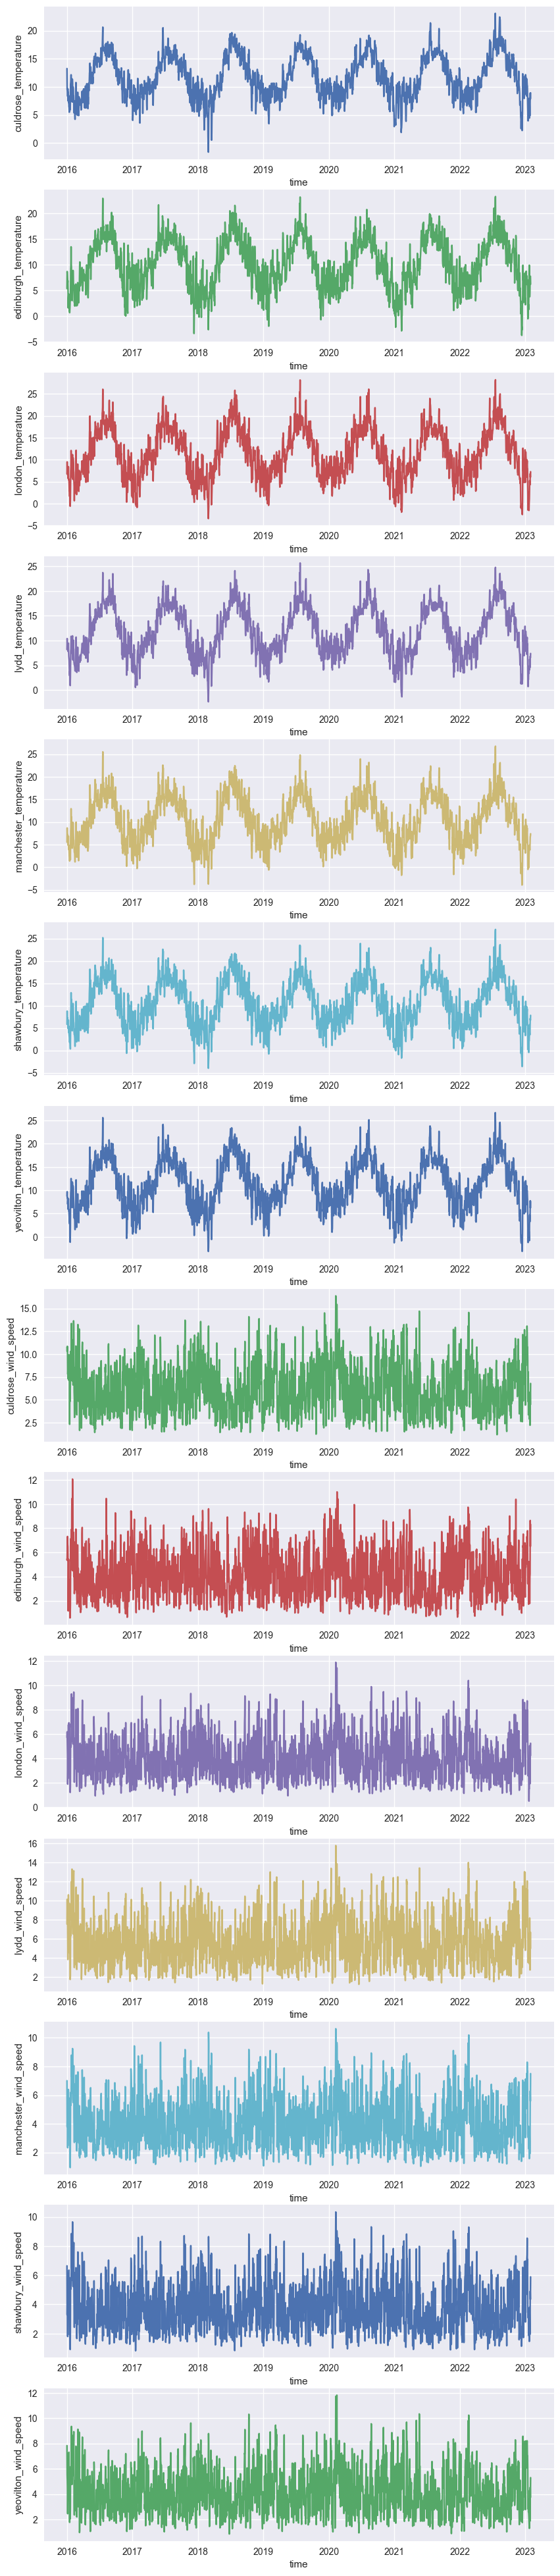

In [13]:
fig, axes = plt.subplots(14, 1, figsize=(10, 50))
for i, col in enumerate(weather_df.columns):
    axes[i].plot(time, weather_df[col].iloc[:-14], c="C"+str(i))
    # axes[i].set_title(col.replace("_temperature", ""))
    axes[i].set_ylabel(col)
    axes[i].set_xlabel("time")

The temperatures are periodic but roughly mirror the LDC demand (i.e. temperature peaks correspond to LDC demand troughs). The wind speed is much noiser and less periodic than the temperature data, which makes sense intuitively, as wind is less seasonal than temperature. There are no obvious outliers, so let's move on.

## Correlation Analysis
---

Let's combine the demand, temperature and wind speed data into a single `DataFrame` and check input/output correlations.

In [14]:
train_df = pd.concat([weather_df[:-14], demand_df], axis=1)
train_df = train_df.set_index(train_df.Date)
train_df = train_df.drop("Date", axis=1)
train_df.corr().iloc[-1, :-1].sort_values(ascending=False)

culdrose_wind_speed       0.322560
lydd_wind_speed           0.257764
yeovilton_wind_speed      0.216498
london_wind_speed         0.210533
shawbury_wind_speed       0.199789
manchester_wind_speed     0.194150
edinburgh_wind_speed      0.150173
culdrose_temperature     -0.889882
edinburgh_temperature    -0.902077
yeovilton_temperature    -0.911355
shawbury_temperature     -0.917196
manchester_temperature   -0.918902
lydd_temperature         -0.924184
london_temperature       -0.926632
Name: Demand, dtype: float64

This is great! We have some really strong correlations here. In general, we see that LDC demand is positively correlated with wind speed and negatively correlated with temperature, which both make intuitive sense. Now let's visualise these relationships.

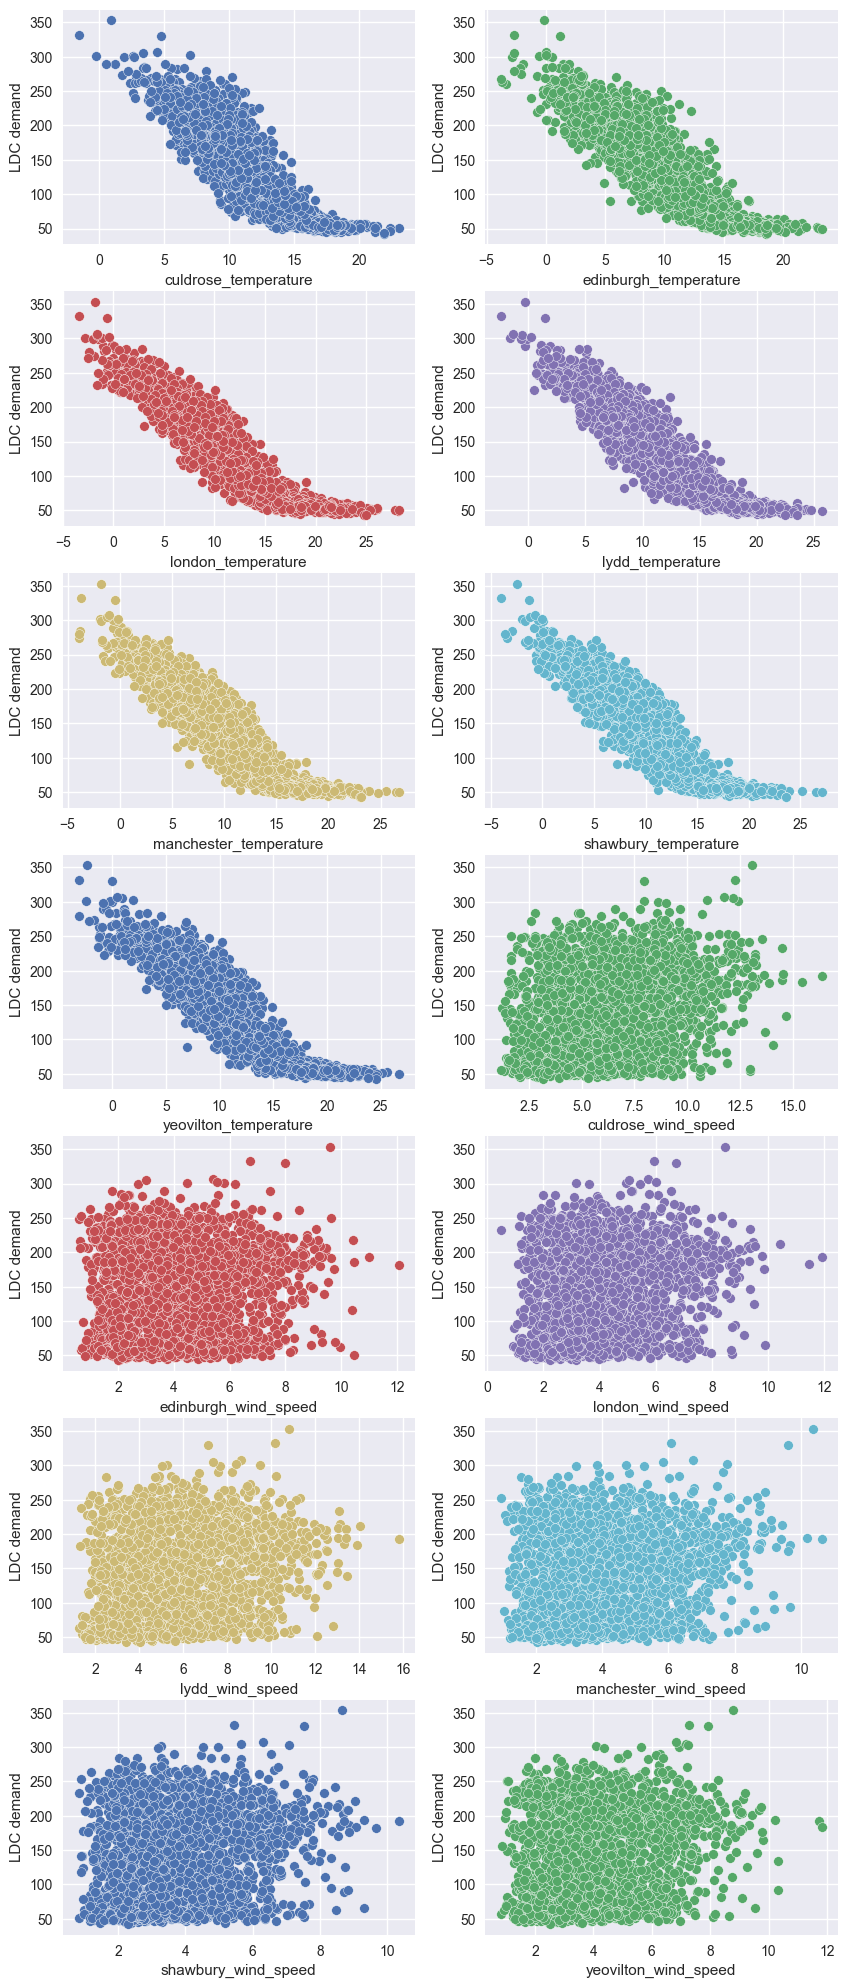

In [15]:
fig, axes = plt.subplots(7, 2, figsize=(10, 25))
for i, col in enumerate(train_df.columns[:-1]):
    axes.flatten()[i].scatter(train_df[col], train_df["Demand"], fc="C"+str(i), ec="w")
    axes.flatten()[i].set_xlabel(col)
    axes.flatten()[i].set_ylabel("LDC demand")

## Model Construction
---

Now we are ready to assemble our model! Seeing as we have quite strong linear relationships between our input features and target variable (and given the time constraints of the task), I have decided to use a simple Bayesian linear regression model (I am a bit biased towards Gaussian processes, but kernel construction becomes a bit tricky in this many dimensions). If I had more time, I would probably try a fancier heteroskedastic / time dependent noise model, or possibly something with heavy tails (like a student-T likelihood). But for now, I will make everything nice and Gaussian.

### Formulation

The model formulation is as follows. Let's assume our LDC demand data $y \in \mathbb{R}^{1 \times 1}$ are noisy observations of some latent function $f$ of our weather data $\mathbf{x} \in \mathbb{R}^{1 \times D}$:

$y = f(\mathbf{x}) + \epsilon \qquad \epsilon \sim \mathcal{N}(0, \sigma^2)$

Let us asssume further that the latent function is a linear combination of some transformation of our input features $\phi(\mathbf{x}) \in \mathbb{R}^{1 \times M}$ and a vector of parameters $\mathbf{\theta} \in \mathbb{R}^{M \times 1}$:

$f(\mathbf{x}) = \phi(\mathbf{x}) \mathbf{\theta}$

Whilst $\phi(\mathbf{x})$ can be any nonlinear transformation of our inputs $\mathbf{x}$, we will consider a simple linear basis:

$\phi(\mathbf{x}) = [1, \mathbf{x}]$ 

Let us stack all our weather data (inputs) into a matrix $\mathbf{X} \in \mathbb{R}^{N \times D}$ and our corresponding LDC demand data into a vector $\mathbf{y} \in \mathbb{R}^{N \times 1}$. We can denote our linear basis $\Phi(\mathbf{X}) \in \mathbb{R}^{N \times M}$. We can write our Gaussian i.i.d. likelihood as:

$p(\mathbf{y}|\mathbf{\theta}) = \mathcal{N}(\mathbf{y; \Phi(\mathbf{X})\mathbf{\theta}}, \sigma^2\mathbf{I}) = \prod_{i} \mathcal{N}(\mathbf{y_i; \phi(\mathbf{x}_i)\mathbf{\theta}}, \sigma^2)$

Let us put a simple Gaussian prior on the parameters $\mathbf{\theta}$:

$p(\mathbf{\theta}) = \mathcal{N}(\mathbf{\theta}; \mathbf{0}, \mathbf{I})$

### Learning

We obtain the marginal likelihood by marginalising the likelihood over the prior -- this integral has a simple closed-form solution using Gaussian linear transformation properties:

$p(\mathbf{y}) = \int p(\mathbf{y}|\mathbf{\theta}) p(\mathbf{\theta}) d\mathbf{\theta} = \int \mathcal{N}(\mathbf{y}; \Phi(\mathbf{X})\mathbf{\theta}, \sigma^2\mathbf{I}) \mathcal{N}(\mathbf{\theta}; \mathbf{0}, \mathbf{I}) d\mathbf{\theta} = \mathcal{N}(\mathbf{y}; \mathbf{y}, \Phi(\mathbf{X})\Phi(\mathbf{X})^{\top} + \sigma^2 \mathbf{I})$

We can use gradient-based optimisation to maximise the marginal likelihood with respect to the learnable parameters, which in this case is just the likelihood variance $\sigma^2$.

### Inference

We can obtain the parameter posterior using Bayes' rule:

$p(\mathbf{\theta}|\mathbf{y}) = \frac{p(\mathbf{y}|\mathbf{\theta})p(\mathbf{\theta})}{\int p(\mathbf{y}|\mathbf{\theta})p(\mathbf{\theta}) d\mathbf{\theta}}$

The posterior mean and covariance can be obtained by transforming the problem into log-space and "completing the square":

$p(\mathbf{\theta}|\mathbf{y}) = \mathcal{N}(\mathbf{\theta}; \mathbf{\mu}, \mathbf{\Sigma})$

$\mathbf{\mu} = \mathbf{\Sigma}(\sigma^{-2}\Phi(\mathbf{X})^{\top}\mathbf{y})$

$\mathbf{\Sigma} = (\mathbf{I} + \sigma^{-2}\Phi(\mathbf{X})^{\top}\Phi(\mathbf{X}))^{-1}$

### Prediction

We can predict new observations $\mathbf{y}^*$ at inputs $\mathbf{X}^*$ by marginalising the likelihood over the posterior. Like the marginal likelihood, we can compute this integral in closed form:

$p(\mathbf{y}^*|\mathbf{y}) = \int p(\mathbf{y}^*|\mathbf{\theta}) p(\mathbf{\theta}|\mathbf{y}) d\mathbf{\theta} = \int \mathcal{N}(\mathbf{y}^*; \Phi(\mathbf{X}^*)\mathbf{\theta}, \sigma^2\mathbf{I}) \mathcal{N}(\mathbf{\theta}; \mathbf{\mu}, \mathbf{\Sigma}) d\mathbf{\theta} = \mathcal{N}(\mathbf{y}^*; \Phi(\mathbf{X}^*)\mathbf{\mu}, \Phi(\mathbf{X}^*) \mathbf{\Sigma} \Phi(\mathbf{X}^*)^{\top} + \sigma^2 \mathbf{I})$

I have defined this Bayesian linear regression model in `src/model.py`, and will simply import it in this notebook.

## Training Set Evaluation
---

Before we set up our model, let us prepare our input and output features. I have included a MinMax scaler inside my BLR model which scales the training data to $(0, 1)$, and reverse scales the predictions back to the original scale, hence why you don't see me doing any feature/target scaling here.

In [83]:
X_train = weather_df.iloc[:-14].to_numpy(dtype=np.float64)
y_train = demand_df.iloc[:, 1:].to_numpy(dtype=np.float64)

Let's train and evaluate the performance of our model on the full training dataset.

training set rmse: 21.283
training set nlpd: 5.133


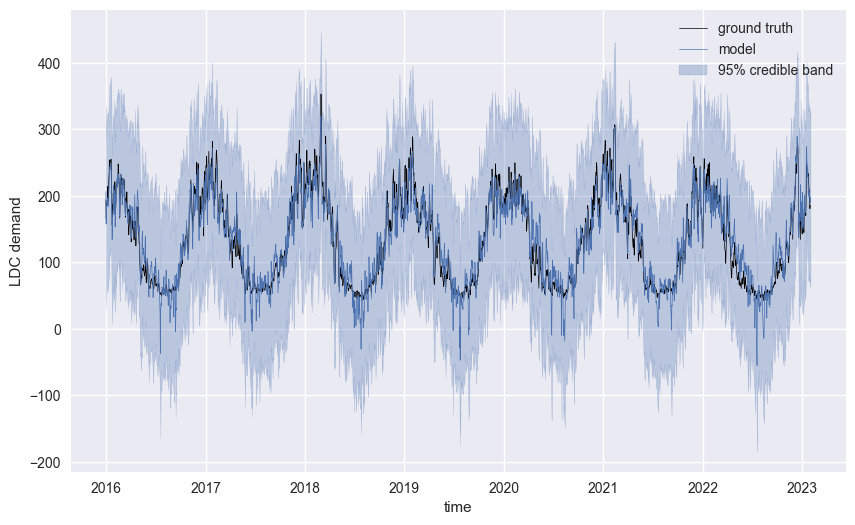

In [92]:
model_1 = BLR(data=(X_train, y_train))
model_1.train()

model_mean, model_var = model_1.predict(X_train)
model_std = np.sqrt(model_var)

print(f"training set rmse: {rmse(model_mean, y_train):.3f}")
print(f"training set nlpd: {gaussian_nlpd(model_mean, model_std, y_train):.3f}")

model_mean, model_std = model_mean.flatten(), model_std.flatten()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(time, y_train, c="k", lw=0.5, label="ground truth")
ax.plot(time, model_mean, c="C0", lw=0.5, label="model")
ax.fill_between(
    time,
    model_mean + 2 * model_std,
    model_mean - 2 * model_std,
    color="C0",
    alpha=0.3,
    label="95% credible band"
)
ax.set_xlabel("time")
ax.set_ylabel("LDC demand")
ax.legend()

plt.show()

The model is clearly picking up the broad trend of the LDC demand, but the RMSE is quite high. NLPD is a bit harder to interpret as a standalone value. Periodically, our model predicts negative LDC demand which is bad -- our Gaussian likelihood assumption may not have been a good one (perhaps something like a LogNormal would have been better).

## Rolling Window Evaluation
---

As our ultimate goal is to produce a forecast for 2023/02/01 - 2023/02/14, a 2-week period for which we have no LDC demand data to evaluate against, we should assess our model's ability to forecast 2 weeks into the future by performing a rolling window evaluation on some historical 2-week periods for which we _do_ have LDC demand data.

train: 		 2016-01-01 00:00:00 - 2022-12-06 00:00:00
forecast: 	 2022-12-07 00:00:00 - 2022-12-20 00:00:00
-----------------------------------------------------------------
forecast rmse: 14.845
forecast nlpd: 5.106


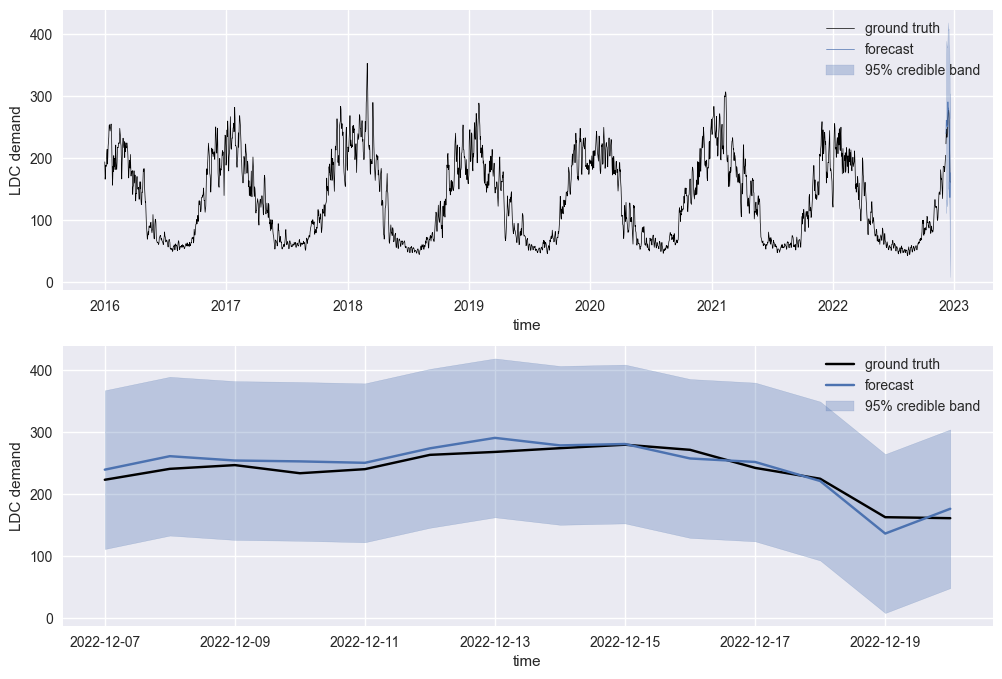

In [120]:
t_train_1 = time[:-4*14]
X_train_1 = X_train[:-4*14]
y_train_1 = y_train[:-4*14]
t_forecast_1 = time[-4*14:-3*14]
X_forecast_1 = X_train[-4*14:-3*14]
y_forecast_1 = y_train[-4*14:-3*14]

model_1 = BLR(data=(X_train_1, y_train_1))
model_1.train()

demand_forecast_mean_1, demand_forecast_var_1 = model_1.predict(X_forecast_1)
demand_forecast_std_1 = np.sqrt(demand_forecast_var_1)

print(f"train: \t\t {t_train_1[0]} - {t_train_1[-1]}")
print(f"forecast: \t {t_forecast_1[0]} - {t_forecast_1[-1]}")
print("-----------------------------------------------------------------")
print(f"forecast rmse: {rmse(demand_forecast_mean_1, y_forecast_1):.3f}")
print(f"forecast nlpd: {gaussian_nlpd(demand_forecast_mean_1, demand_forecast_std_1, y_forecast_1):.3f}")

demand_forecast_mean_1 = demand_forecast_mean_1.flatten()
demand_forecast_std_1 = demand_forecast_std_1.flatten()

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].plot(t_train_1, y_train_1, c="k", lw=0.5)
axes[0].plot(t_forecast_1, y_forecast_1, c="k", lw=0.5, label="ground truth")
axes[0].plot(t_forecast_1, demand_forecast_mean_1, c="C0", lw=0.5, label="forecast")
axes[0].fill_between(
    t_forecast_1,
    demand_forecast_mean_1 + 2 * demand_forecast_std_1,
    demand_forecast_mean_1 - 2 * demand_forecast_std_1,
    color="C0",
    alpha=0.3,
    label="95% credible band"
)
axes[0].set_xlabel("time")
axes[0].set_ylabel("LDC demand")
axes[0].legend()

axes[1].plot(t_forecast_1, y_forecast_1, c="k", label="ground truth")
axes[1].plot(t_forecast_1, demand_forecast_mean_1, c="C0", label="forecast")
axes[1].fill_between(
    t_forecast_1,
    demand_forecast_mean_1 + 2 * demand_forecast_std_1,
    demand_forecast_mean_1 - 2 * demand_forecast_std_1,
    color="C0",
    alpha=0.3,
    label="95% credible band"
)
axes[1].set_xlabel("time")
axes[1].set_ylabel("LDC demand")
axes[1].legend()

plt.show()

train: 		 2016-01-01 00:00:00 - 2022-12-20 00:00:00
forecast: 	 2022-12-21 00:00:00 - 2023-01-03 00:00:00
-----------------------------------------------------------------
forecast rmse: 22.877
forecast nlpd: 5.142


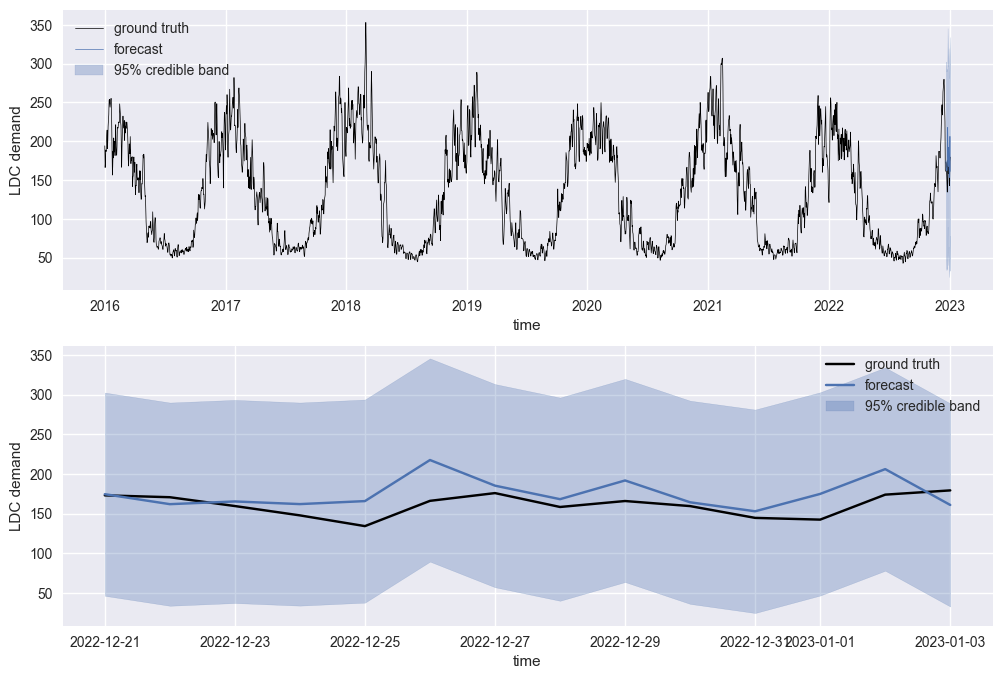

In [121]:
t_train_2 = time[:-3*14]
X_train_2 = X_train[:-3*14]
y_train_2 = y_train[:-3*14]
t_forecast_2 = time[-3*14:-2*14]
X_forecast_2 = X_train[-3*14:-2*14]
y_forecast_2 = y_train[-3*14:-2*14]

model_2 = BLR(data=(X_train_2, y_train_2))
model_2.train()

demand_forecast_mean_2, demand_forecast_var_2 = model_2.predict(X_forecast_2)
demand_forecast_std_2 = np.sqrt(demand_forecast_var_2)

print(f"train: \t\t {t_train_2[0]} - {t_train_2[-1]}")
print(f"forecast: \t {t_forecast_2[0]} - {t_forecast_2[-1]}")
print("-----------------------------------------------------------------")
print(f"forecast rmse: {rmse(demand_forecast_mean_2, y_forecast_2):.3f}")
print(f"forecast nlpd: {gaussian_nlpd(demand_forecast_mean_2, demand_forecast_std_2, y_forecast_2):.3f}")

demand_forecast_mean_2 = demand_forecast_mean_2.flatten()
demand_forecast_std_2 = demand_forecast_std_2.flatten()

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].plot(t_train_2, y_train_2, c="k", lw=0.5)
axes[0].plot(t_forecast_2, y_forecast_2, c="k", lw=0.5, label="ground truth")
axes[0].plot(t_forecast_2, demand_forecast_mean_2, c="C0", lw=0.5, label="forecast")
axes[0].fill_between(
    t_forecast_2,
    demand_forecast_mean_2 + 2 * demand_forecast_std_2,
    demand_forecast_mean_2 - 2 * demand_forecast_std_2,
    color="C0",
    alpha=0.3,
    label="95% credible band"
)
axes[0].set_xlabel("time")
axes[0].set_ylabel("LDC demand")
axes[0].legend()

axes[1].plot(t_forecast_2, y_forecast_2, c="k", label="ground truth")
axes[1].plot(t_forecast_2, demand_forecast_mean_2, c="C0", label="forecast")
axes[1].fill_between(
    t_forecast_2,
    demand_forecast_mean_2 + 2 * demand_forecast_std_2,
    demand_forecast_mean_2 - 2 * demand_forecast_std_2,
    color="C0",
    alpha=0.3,
    label="95% credible band"
)
axes[1].set_xlabel("time")
axes[1].set_ylabel("LDC demand")
axes[1].legend()

plt.show()

train: 		 2016-01-01 00:00:00 - 2023-01-03 00:00:00
forecast: 	 2023-01-04 00:00:00 - 2023-01-17 00:00:00
-----------------------------------------------------------------
forecast rmse: 17.189
forecast nlpd: 5.114


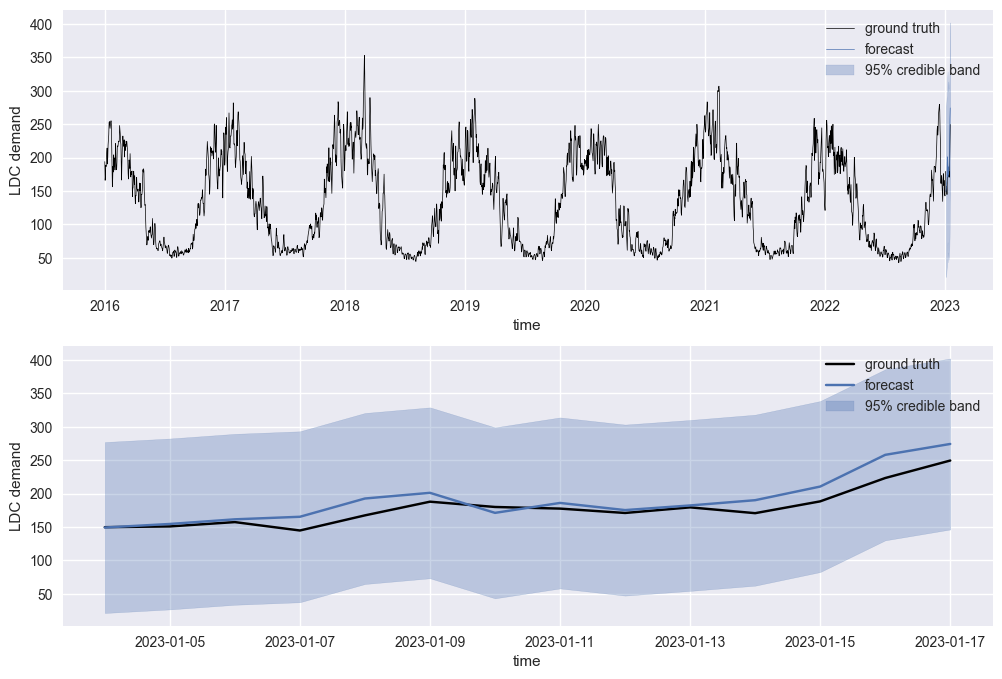

In [122]:
t_train_3 = time[:-2*14]
X_train_3 = X_train[:-2*14]
y_train_3 = y_train[:-2*14]
t_forecast_3 = time[-2*14:-1*14]
X_forecast_3 = X_train[-2*14:-1*14]
y_forecast_3 = y_train[-2*14:-1*14]

model_3 = BLR(data=(X_train_3, y_train_3))
model_3.train()

demand_forecast_mean_3, demand_forecast_var_3 = model_3.predict(X_forecast_3)
demand_forecast_std_3 = np.sqrt(demand_forecast_var_3)

print(f"train: \t\t {t_train_3[0]} - {t_train_3[-1]}")
print(f"forecast: \t {t_forecast_3[0]} - {t_forecast_3[-1]}")
print("-----------------------------------------------------------------")
print(f"forecast rmse: {rmse(demand_forecast_mean_3, y_forecast_3):.3f}")
print(f"forecast nlpd: {gaussian_nlpd(demand_forecast_mean_3, demand_forecast_std_3, y_forecast_3):.3f}")

demand_forecast_mean_3 = demand_forecast_mean_3.flatten()
demand_forecast_std_3 = demand_forecast_std_3.flatten()

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].plot(t_train_3, y_train_3, c="k", lw=0.5)
axes[0].plot(t_forecast_3, y_forecast_3, c="k", lw=0.5, label="ground truth")
axes[0].plot(t_forecast_3, demand_forecast_mean_3, c="C0", lw=0.5, label="forecast")
axes[0].fill_between(
    t_forecast_3,
    demand_forecast_mean_3 + 2 * demand_forecast_std_3,
    demand_forecast_mean_3 - 2 * demand_forecast_std_3,
    color="C0",
    alpha=0.3,
    label="95% credible band"
)
axes[0].set_xlabel("time")
axes[0].set_ylabel("LDC demand")
axes[0].legend()

axes[1].plot(t_forecast_3, y_forecast_3, c="k", label="ground truth")
axes[1].plot(t_forecast_3, demand_forecast_mean_3, c="C0", label="forecast")
axes[1].fill_between(
    t_forecast_3,
    demand_forecast_mean_3 + 2 * demand_forecast_std_3,
    demand_forecast_mean_3 - 2 * demand_forecast_std_3,
    color="C0",
    alpha=0.3,
    label="95% credible band"
)
axes[1].set_xlabel("time")
axes[1].set_ylabel("LDC demand")
axes[1].legend()

plt.show()

train: 		 2016-01-01 00:00:00 - 2023-01-17 00:00:00
forecast: 	 2023-01-18 00:00:00 - 2023-01-31 00:00:00
-----------------------------------------------------------------
forecast rmse: 13.501
forecast nlpd: 5.101


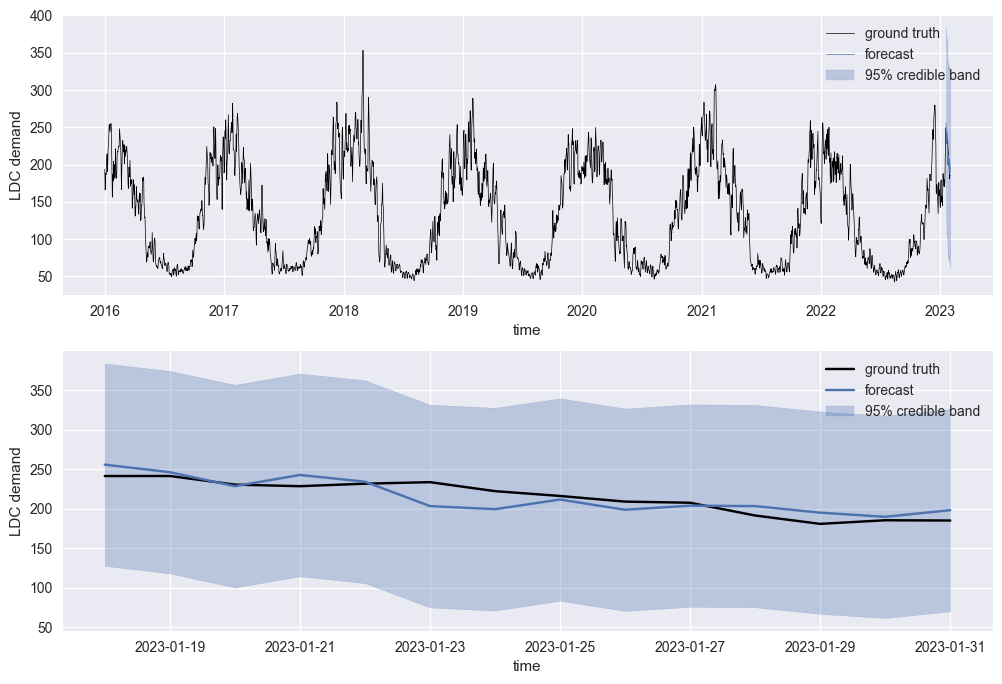

In [123]:
t_train_4 = time[:-1*14]
X_train_4 = X_train[:-1*14]
y_train_4 = y_train[:-1*14]
t_forecast_4 = time[-1*14:]
X_forecast_4 = X_train[-1*14:]
y_forecast_4 = y_train[-1*14:]

model_4 = BLR(data=(X_train_4, y_train_4))
model_4.train()

demand_forecast_mean_4, demand_forecast_var_4 = model_4.predict(X_forecast_4)
demand_forecast_std_4 = np.sqrt(demand_forecast_var_4)

print(f"train: \t\t {t_train_4[0]} - {t_train_4[-1]}")
print(f"forecast: \t {t_forecast_4[0]} - {t_forecast_4[-1]}")
print("-----------------------------------------------------------------")
print(f"forecast rmse: {rmse(demand_forecast_mean_4, y_forecast_4):.3f}")
print(f"forecast nlpd: {gaussian_nlpd(demand_forecast_mean_4, demand_forecast_std_4, y_forecast_4):.3f}")

demand_forecast_mean_4 = demand_forecast_mean_4.flatten()
demand_forecast_std_4 = demand_forecast_std_4.flatten()

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].plot(t_train_4, y_train_4, c="k", lw=0.5)
axes[0].plot(t_forecast_4, y_forecast_4, c="k", lw=0.5, label="ground truth")
axes[0].plot(t_forecast_4, demand_forecast_mean_4, c="C0", lw=0.5, label="forecast")
axes[0].fill_between(
    t_forecast_4,
    demand_forecast_mean_4 + 2 * demand_forecast_std_4,
    demand_forecast_mean_4 - 2 * demand_forecast_std_4,
    color="C0",
    alpha=0.3,
    label="95% credible band"
)
axes[0].set_xlabel("time")
axes[0].set_ylabel("LDC demand")
axes[0].legend()

axes[1].plot(t_forecast_4, y_forecast_4, c="k", label="ground truth")
axes[1].plot(t_forecast_4, demand_forecast_mean_4, c="C0", label="forecast")
axes[1].fill_between(
    t_forecast_4,
    demand_forecast_mean_4 + 2 * demand_forecast_std_4,
    demand_forecast_mean_4 - 2 * demand_forecast_std_4,
    color="C0",
    alpha=0.3,
    label="95% credible band"
)
axes[1].set_xlabel("time")
axes[1].set_ylabel("LDC demand")
axes[1].legend()

plt.show()

Overall, the NLPD is quite steady from forecast to forecast, but the RMSE fluctuated from about 13 - 22, which is significant variation. Let's move on to our final forecast.

## Forecasting LDC Demand from 2023/02/01 - 2023/02/14
---

Below is our final forecast, which we are not able to evaluate as we do not have the true LDC demand data for this period.

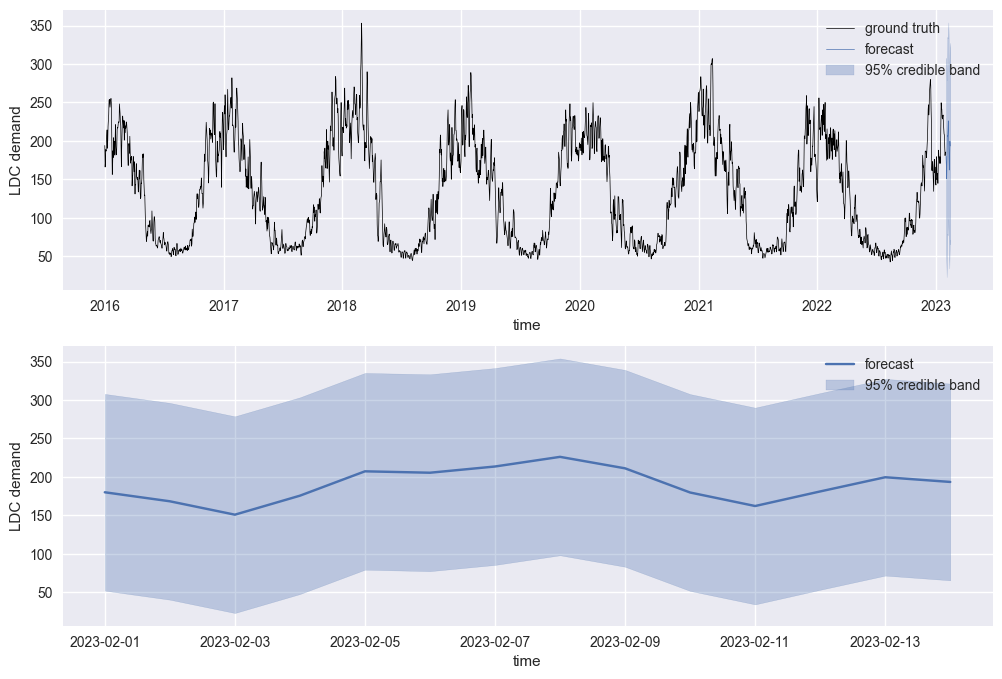

In [132]:
start = datetime.strptime("2023-02-01", "%Y-%m-%d")
end = datetime.strptime("2023-02-15", "%Y-%m-%d")
t_forecast = [start + timedelta(days=x) for x in range(0, (end-start).days)]

X_forecast = weather_df.iloc[-14:].to_numpy(dtype=np.float64)

model = BLR(data=(X_train, y_train))
model.train()

demand_forecast_mean, demand_forecast_var = model.predict(X_forecast)
demand_forecast_std = np.sqrt(demand_forecast_var)

demand_forecast_mean = demand_forecast_mean.flatten()
demand_forecast_std = demand_forecast_std.flatten()

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].plot(time, y_train, c="k", lw=0.5, label="ground truth")
axes[0].plot(t_forecast, demand_forecast_mean, c="C0", lw=0.5, label="forecast")
axes[0].fill_between(
    t_forecast,
    demand_forecast_mean + 2 * demand_forecast_std,
    demand_forecast_mean - 2 * demand_forecast_std,
    color="C0",
    alpha=0.3,
    label="95% credible band"
)
axes[0].set_xlabel("time")
axes[0].set_ylabel("LDC demand")
axes[0].legend()

axes[1].plot(t_forecast, demand_forecast_mean, c="C0", label="forecast")
axes[1].fill_between(
    t_forecast,
    demand_forecast_mean + 2 * demand_forecast_std,
    demand_forecast_mean - 2 * demand_forecast_std,
    color="C0",
    alpha=0.3,
    label="95% credible band"
)
axes[1].set_xlabel("time")
axes[1].set_ylabel("LDC demand")
axes[1].legend()

plt.show()


## Conclusion + Extensions
---

I think that my Bayesian linear regression forecasting model is a reasonable baseline to compare other models against, but could certainly be improved. If I had more time, here are some possible improvements I would attempt:

- Treat hourly wind speed / temperature as independent features
- Replace closed-form BLR with a variational approximation and try some different likelihoods:
    - Likelihood with positive support (e.g. LogNormal, Gamma)
    - Heteroskedastic / time dependent noise model
- Reduce the input dimensionality and try a Gaussian process with a sum of Matern, Periodic and Linear kernels
- Try some deep learning models (the downside is that these both produce deterministic predictions):
    - Gated RNN (LSTM)
    - Transformer

If I had more time, I would also write docstrings and clean up my code!